In [1]:
import os
import numpy as np
import pandas as pd
import nltk
import keras
import six
import matplotlib.pyplot as plt
import json
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import TimeDistributed,Conv1D,Dense,Embedding,Input,Dropout,LSTM,Bidirectional,AveragePooling1D,Flatten,concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import *

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('spanish'))

[nltk_data] Downloading package punkt to /home/roberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/roberto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/roberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/roberto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
#Abro el archivo en el que se encuentra el dataset de los problemas
with open('singleop.json', 'r') as f:
    datastore = json.load(f)

In [4]:
# Archivo que contiene un listado de nombres
nombres = pd.read_csv('nombres-2015.csv')
names = pd.read_csv('yob2019.txt', header=None)    

In [5]:
dataset2 = pd.read_csv('problemas_adicionales2.csv')

In [6]:
preguntas = []
respuestas = []
ecuaciones = []
alineacion = []

for item in datastore:
    preguntas.append(item['sQuestion'])
    respuestas.append(item['lSolutions'])
    ecuaciones.append(item['lEquations'])
    alineacion.append(item['lAlignments'])

In [7]:
# Necesito convertir el dataset en un problema de clasificacion para que la red neuronal pueda identificar
# si estoy tratando de resolver un problema de sumas, restas, multiplicaciones o divisiones.
# Esto va a crear una lista con el tipo de operacion y que va a ser el resultado a inferir.
operaciones = []
sumas =0
restas =0
multiplicaciones =0
divisiones = 0
otras = 0
#Clasifico las operaciones en 0 para sumas, 1 para restas, 2 para multiplicaciones, 3 para divisiones y 4 sino lo encuentro.
for operacion in ecuaciones:
    if (operacion[0].find('+')>=0):
        operaciones.append(0)
        sumas = sumas + 1
    elif (operacion[0].find('-') >= 0 ):
        operaciones.append(1)
        restas = restas + 1
    elif(operacion[0].find('*') >=0):
        operaciones.append(2)
        multiplicaciones = multiplicaciones + 1
    elif(operacion[0].find('/')):
        operaciones.append(3)
        divisiones = divisiones + 1
    else:
        operaciones.append(4)
        otras = otras + 1

print('Tengo ', sumas, ' sumas ', restas, ' restas, ', multiplicaciones, ' multiplicaciones, ', divisiones, ' divisiones y otras operaciones ', otras)

Tengo  159  sumas  162  restas,  117  multiplicaciones,  124  divisiones y otras operaciones  0


In [8]:
preguntas2 = dataset2['Preguntas'].tolist()
respuestas2 = dataset2['respuestas'].tolist()

In [9]:
preguntas3 = preguntas + preguntas2
respuestas3 = operaciones + respuestas2

In [10]:
#El listado de nombres lo voy a truncar a los 15K primeros, dado que el resto son nombres muy residuales.
nombres_ = nombres['nombre'][:15000]

In [11]:
names_= names[0]

In [12]:
nombres_ = nombres_.append(names_)

In [13]:
st_words = list(stop_words)

In [14]:
nom = nombres['nombre'].values.tolist()

In [15]:
nomb =  nom + st_words

In [16]:
nomb[-1]

'tenemos'

In [17]:
# El vector preguntas_sin, consiste en las preguntas a las que voy a eliminar todos los nombres propios que no
# anaden ningun valor al conjunto de preguntas. No quiero que esos nombres se procesen y por tanto los elimino.
def eliminar_palabras(dataset, stopw):
    preguntas_sin = []
    for palabras in dataset:
        frases = [word for word in palabras.split(' ') if word not in stopw]
        frases = " ".join(frases)
        preguntas_sin.append(frases)
    return preguntas_sin

In [18]:
preguntas_sin = eliminar_palabras(preguntas3, nomb)

In [19]:
from random import shuffle

def mezclarPalabras(frase):
    separar = frase.split()
    shuffle(separar)
    return ' '.join(separar)

In [20]:
len(respuestas3)

974

In [21]:
preguntas_mezcla = []
resp_mezcla = []

for i, pregunta in enumerate(preguntas_sin):
    preguntas_mezcla.append(pregunta)
    resp_mezcla.append(respuestas3[i])
    print(i)
    print(len(resp_mezcla))
    for j in range(10):
        preguntas_mezcla.append(mezclarPalabras(pregunta))
        resp_mezcla.append(respuestas3[i])


0
1
1
12
2
23
3
34
4
45
5
56
6
67
7
78
8
89
9
100
10
111
11
122
12
133
13
144
14
155
15
166
16
177
17
188
18
199
19
210
20
221
21
232
22
243
23
254
24
265
25
276
26
287
27
298
28
309
29
320
30
331
31
342
32
353
33
364
34
375
35
386
36
397
37
408
38
419
39
430
40
441
41
452
42
463
43
474
44
485
45
496
46
507
47
518
48
529
49
540
50
551
51
562
52
573
53
584
54
595
55
606
56
617
57
628
58
639
59
650
60
661
61
672
62
683
63
694
64
705
65
716
66
727
67
738
68
749
69
760
70
771
71
782
72
793
73
804
74
815
75
826
76
837
77
848
78
859
79
870
80
881
81
892
82
903
83
914
84
925
85
936
86
947
87
958
88
969
89
980
90
991
91
1002
92
1013
93
1024
94
1035
95
1046
96
1057
97
1068
98
1079
99
1090
100
1101
101
1112
102
1123
103
1134
104
1145
105
1156
106
1167
107
1178
108
1189
109
1200
110
1211
111
1222
112
1233
113
1244
114
1255
115
1266
116
1277
117
1288
118
1299
119
1310
120
1321
121
1332
122
1343
123
1354
124
1365
125
1376
126
1387
127
1398
128
1409
129
1420
130
1431
131
1442
132
1453
133
1464
134
1

In [22]:
len(preguntas_mezcla)

10714

In [23]:
preguntas3[-1]

'Mar tiene 85 céntimos y quiere comprar postales. Cada postal cuesta 9 céntimos ¿Cuántas postales puede comprar?'

In [24]:
preguntas_mezcla[1]

'¿cuántas botella 7 caja? Si pone dentro, tapas 7 tapas caja tapas'

In [25]:
from sklearn.utils import shuffle

preguntas3, respuestas3 = shuffle(preguntas_mezcla,resp_mezcla)

In [26]:
def eliminarStopWords(preg):
    frases = []
    palabra_sola = []
    tokenizer = RegexpTokenizer(r'\w+')

    for i,pregunta in enumerate(preg):
        palabras = tokenizer.tokenize(pregunta)
        preguntas_w = []
        for j, palabra in enumerate(reversed(palabras)):
            preguntas_w.append(palabra)
            palabra_sola.append(palabra)
            if(j == 10):
                continue
        frases.append(preguntas_w)
    return frases, palabra_sola

In [27]:
#Es necesario extraer las palabras del conjunto de test.

frases, palabra_sola = eliminarStopWords(preguntas3[:8500])
frases_test, _ = eliminarStopWords(preguntas3[8500:])

In [28]:
palabras_unicas = set(palabra_sola)

In [29]:
len(palabras_unicas)

2305

In [30]:
p_unicas = list(palabras_unicas)

#Voy a convertir los indices a escala logaritmica para evitar que puedan reventar los pesos en la red neuronal
vocabulario = {p:i for i, p in enumerate(p_unicas)}

In [31]:
vocabulario['<OOP>'] = len(vocabulario)

In [32]:
tamanoMedio = 0
tamanoTotal = 0

for pregunta in frases:
    if(len(pregunta) > tamanoTotal):
        tamanoTotal = len(pregunta)
    tamanoMedio = tamanoMedio + len(pregunta)

print("El tamano max es ", tamanoTotal, " y la media de la longitud de las frases es de", tamanoMedio/len(frases))

El tamano max es  31  y la media de la longitud de las frases es de 12.821294117647058


In [33]:
# Voy a meter en este vector todas mis preguntas y todas las palabras.
# Para esta prueba, vamos a poner en la posición de la frase, el número de la palabra que estamos procesando.
# El objetivo es procesar las palabras teniendo en cuenta el orden secuencial de la frase.
training_X = np.zeros([len(frases), tamanoTotal, len(palabras_unicas)+1])
test_X = np.zeros([len(frases_test), tamanoTotal, len(palabras_unicas)+1])

In [34]:
training_X.shape

(8500, 31, 2306)

In [35]:
for i, pregunta in enumerate(frases):
    for j, palabras in enumerate(pregunta):
        training_X[i, tamanoTotal - len(pregunta) + j, vocabulario[palabras]] = 1.0

In [36]:
vocabulario.keys()

dict_keys(['cereales', 'vagaba', 'semanas', 'blancas', 'midió', 'líneas', 'premios', 'anillos', 'vez', '3', 'preparando', 'anotaría', 'borde', 'jugando', 'tobogán', 'tickets', 'asientos', 'promedio', '101', '121', 'suministros', 'larga', 'pegar', 'madre', '57', 'fuente', 'Barcelona', 'anotaron', 'Bobby', '2315', 'cartero', 'zoológico', 'crecido', 'recoger', 'Cuan', 'catedral', '14', 'afila', 'barra', 'euros', 'Roger', 'contiene', 'son', 'dan', 'velitas', 'arvejas', 'tomaron', 'nidos', 'Michelle', 'autobús', 'completas', 'tocado', 'fotogramas', 'depósitos', 'muñecos', 'patas', 'fruteros', 'have', 'fresas', 'llegaron', 'alcanzara', 'camión', 'recibido', 'problemas', 'estudiante', 'sentados', 'manzana', '324', 'Susan', 'quedan', 'competición', 'hermano', 'bajaron', 'directo', 'blusa', 'tiempo', 'turistas', 'unas', 'paga', 'colmena', 'gomas', 'pegó', 'B', 'Cuántos', 'planos', 'En', 'uno', '63', 'Juanjo', 'agregan', 'contenedor', 'Arriba', 'Lansing', 'canasta', 'preparó', 'igual', 'gradas',

In [37]:
for i, pregunta in enumerate(frases_test):
    for j, palabras in enumerate(pregunta):
        if palabras in vocabulario:
            test_X[i, tamanoTotal - len(pregunta) + j, vocabulario[palabras]] = 1.0
        else:
            test_X[i, tamanoTotal - len(pregunta) + j, vocabulario['<OOP>']] = 1.0

In [38]:
# Importante, no tokenizar las palabras del conjunto de test para evitar overfitting y crear espacios para
# palabras no vistas.

training_y = np.asarray(respuestas3[:8500])
test_y = np.asarray(respuestas3[8500:])

In [39]:
embedding_dim = 16

model = keras.Sequential([
    keras.layers.Flatten(),
    keras.layers.Embedding(len(vocabulario), embedding_dim),
    keras.layers.GlobalAveragePooling1D(),
    keras.layers.Dense(36, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(4, activation='softmax')
])
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [40]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [41]:
history = model.fit(training_X, training_y, epochs = 140, validation_data=(test_X, test_y))

Epoch 1/140
266/266 [==============================] - 60s 226ms/step - loss: 1.3445 - accuracy: 0.3722 - val_loss: 1.3409 - val_accuracy: 0.3722
Epoch 2/140
266/266 [==============================] - 61s 230ms/step - loss: 1.3423 - accuracy: 0.3728 - val_loss: 1.3440 - val_accuracy: 0.3722
Epoch 3/140
266/266 [==============================] - 60s 224ms/step - loss: 1.3421 - accuracy: 0.3728 - val_loss: 1.3410 - val_accuracy: 0.3722
Epoch 4/140
266/266 [==============================] - 60s 226ms/step - loss: 1.3421 - accuracy: 0.3728 - val_loss: 1.3410 - val_accuracy: 0.3722
Epoch 5/140
266/266 [==============================] - 61s 228ms/step - loss: 1.3413 - accuracy: 0.3728 - val_loss: 1.3408 - val_accuracy: 0.3722
Epoch 6/140
266/266 [==============================] - 60s 227ms/step - loss: 1.3416 - accuracy: 0.3728 - val_loss: 1.3408 - val_accuracy: 0.3722
Epoch 7/140
266/266 [==============================] - 62s 231ms/step - loss: 1.3416 - accuracy: 0.3728 - val_loss: 1.3413 -

Epoch 57/140
266/266 [==============================] - 53s 201ms/step - loss: 1.3409 - accuracy: 0.3728 - val_loss: 1.3408 - val_accuracy: 0.3722
Epoch 58/140
266/266 [==============================] - 54s 204ms/step - loss: 1.3404 - accuracy: 0.3728 - val_loss: 1.3408 - val_accuracy: 0.3722
Epoch 59/140
266/266 [==============================] - 53s 201ms/step - loss: 1.3407 - accuracy: 0.3728 - val_loss: 1.3408 - val_accuracy: 0.3722
Epoch 60/140
266/266 [==============================] - 54s 202ms/step - loss: 1.3405 - accuracy: 0.3728 - val_loss: 1.3408 - val_accuracy: 0.3722
Epoch 61/140
266/266 [==============================] - 54s 201ms/step - loss: 1.3409 - accuracy: 0.3728 - val_loss: 1.3408 - val_accuracy: 0.3722
Epoch 62/140
266/266 [==============================] - 53s 200ms/step - loss: 1.3406 - accuracy: 0.3728 - val_loss: 1.3413 - val_accuracy: 0.3722
Epoch 63/140
266/266 [==============================] - 53s 201ms/step - loss: 1.3406 - accuracy: 0.3728 - val_loss: 1

266/266 [==============================] - 54s 202ms/step - loss: 1.3405 - accuracy: 0.3728 - val_loss: 1.3408 - val_accuracy: 0.3722
Epoch 113/140
266/266 [==============================] - 54s 203ms/step - loss: 1.3406 - accuracy: 0.3728 - val_loss: 1.3408 - val_accuracy: 0.3722
Epoch 114/140
266/266 [==============================] - 53s 201ms/step - loss: 1.3407 - accuracy: 0.3728 - val_loss: 1.3408 - val_accuracy: 0.3722
Epoch 115/140
266/266 [==============================] - 54s 203ms/step - loss: 1.3406 - accuracy: 0.3728 - val_loss: 1.3408 - val_accuracy: 0.3722
Epoch 116/140
266/266 [==============================] - 54s 203ms/step - loss: 1.3404 - accuracy: 0.3728 - val_loss: 1.3408 - val_accuracy: 0.3722
Epoch 117/140
266/266 [==============================] - 54s 202ms/step - loss: 1.3405 - accuracy: 0.3728 - val_loss: 1.3407 - val_accuracy: 0.3722
Epoch 118/140
266/266 [==============================] - 54s 202ms/step - loss: 1.3405 - accuracy: 0.3728 - val_loss: 1.3408 -

In [44]:
model2 = keras.Sequential([
    keras.layers.Bidirectional(keras.layers.LSTM(128, dropout = 0.2, input_shape=[len(vocabulario), training_X.shape[1], training_X.shape[2]])),
    keras.layers.Dense(4, activation='softmax')
])

opt = keras.optimizers.RMSprop(learning_rate=0.001,rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)

#opt = keras.optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
#opt = keras.optimizers.Adam(learning_rate = 0.0001)
model2.compile(loss='sparse_categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

In [45]:
history2 = model2.fit(training_X, training_y, epochs = 240, batch_size= 128, validation_data=(test_X, test_y))

Epoch 1/240
67/67 [==============================] - 66s 988ms/step - loss: 0.7078 - accuracy: 0.7116 - val_loss: 0.3008 - val_accuracy: 0.8794
Epoch 2/240
67/67 [==============================] - 79s 1s/step - loss: 0.2277 - accuracy: 0.9267 - val_loss: 0.1213 - val_accuracy: 0.9666
Epoch 3/240
67/67 [==============================] - 77s 1s/step - loss: 0.1279 - accuracy: 0.9619 - val_loss: 0.0507 - val_accuracy: 0.9855
Epoch 4/240
67/67 [==============================] - 78s 1s/step - loss: 0.1424 - accuracy: 0.9688 - val_loss: 0.0319 - val_accuracy: 0.9905
Epoch 5/240
67/67 [==============================] - 73s 1s/step - loss: 0.0587 - accuracy: 0.9834 - val_loss: 0.0199 - val_accuracy: 0.9959
Epoch 6/240
67/67 [==============================] - 75s 1s/step - loss: 0.0487 - accuracy: 0.9856 - val_loss: 0.0234 - val_accuracy: 0.9986
Epoch 7/240
67/67 [==============================] - 84s 1s/step - loss: 0.0432 - accuracy: 0.9862 - val_loss: 0.0178 - val_accuracy: 0.9964
Epoch 8/24

67/67 [==============================] - 62s 929ms/step - loss: 0.0028 - accuracy: 0.9991 - val_loss: 0.0090 - val_accuracy: 0.9973
Epoch 59/240
67/67 [==============================] - 62s 923ms/step - loss: 0.0042 - accuracy: 0.9986 - val_loss: 0.0045 - val_accuracy: 0.9986
Epoch 60/240
67/67 [==============================] - 65s 977ms/step - loss: 0.0041 - accuracy: 0.9987 - val_loss: 0.0067 - val_accuracy: 0.9982
Epoch 61/240
67/67 [==============================] - 64s 952ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.0063 - val_accuracy: 0.9982
Epoch 62/240
67/67 [==============================] - 67s 998ms/step - loss: 0.0040 - accuracy: 0.9985 - val_loss: 0.0068 - val_accuracy: 0.9982
Epoch 63/240
67/67 [==============================] - 63s 936ms/step - loss: 0.0050 - accuracy: 0.9978 - val_loss: 0.0064 - val_accuracy: 0.9982
Epoch 64/240
67/67 [==============================] - 64s 959ms/step - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.0146 - val_accuracy: 0.996

67/67 [==============================] - 62s 929ms/step - loss: 0.0022 - accuracy: 0.9991 - val_loss: 0.0105 - val_accuracy: 0.9973
Epoch 115/240
67/67 [==============================] - 65s 963ms/step - loss: 0.0030 - accuracy: 0.9986 - val_loss: 0.0166 - val_accuracy: 0.9968
Epoch 116/240
67/67 [==============================] - 63s 943ms/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.0151 - val_accuracy: 0.9982
Epoch 117/240
67/67 [==============================] - 63s 941ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.0110 - val_accuracy: 0.9982
Epoch 118/240
67/67 [==============================] - 63s 937ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0131 - val_accuracy: 0.9977
Epoch 119/240
67/67 [==============================] - 63s 941ms/step - loss: 0.0033 - accuracy: 0.9988 - val_loss: 0.0124 - val_accuracy: 0.9982
Epoch 120/240
67/67 [==============================] - 67s 995ms/step - loss: 0.0019 - accuracy: 0.9993 - val_loss: 0.0157 - val_accuracy:

Epoch 171/240
67/67 [==============================] - 86s 1s/step - loss: 0.0029 - accuracy: 0.9988 - val_loss: 0.0146 - val_accuracy: 0.9977
Epoch 172/240
67/67 [==============================] - 88s 1s/step - loss: 0.0014 - accuracy: 0.9995 - val_loss: 0.0149 - val_accuracy: 0.9982
Epoch 173/240
67/67 [==============================] - 92s 1s/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0163 - val_accuracy: 0.9982
Epoch 174/240
67/67 [==============================] - 87s 1s/step - loss: 0.0012 - accuracy: 0.9995 - val_loss: 0.0166 - val_accuracy: 0.9977
Epoch 175/240
67/67 [==============================] - 85s 1s/step - loss: 0.0020 - accuracy: 0.9994 - val_loss: 0.0101 - val_accuracy: 0.9986
Epoch 176/240
67/67 [==============================] - 81s 1s/step - loss: 0.0063 - accuracy: 0.9986 - val_loss: 0.0147 - val_accuracy: 0.9982
Epoch 177/240
67/67 [==============================] - 76s 1s/step - loss: 0.0017 - accuracy: 0.9992 - val_loss: 0.0189 - val_accuracy: 0.9982

67/67 [==============================] - 66s 980ms/step - loss: 0.0027 - accuracy: 0.9989 - val_loss: 0.0155 - val_accuracy: 0.9986
Epoch 229/240
67/67 [==============================] - 62s 929ms/step - loss: 0.0048 - accuracy: 0.9992 - val_loss: 0.0151 - val_accuracy: 0.9982
Epoch 230/240
67/67 [==============================] - 63s 947ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0156 - val_accuracy: 0.9982
Epoch 231/240
67/67 [==============================] - 63s 935ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0159 - val_accuracy: 0.9982
Epoch 232/240
67/67 [==============================] - 63s 940ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0207 - val_accuracy: 0.9968
Epoch 233/240
67/67 [==============================] - 62s 926ms/step - loss: 0.0039 - accuracy: 0.9992 - val_loss: 0.0207 - val_accuracy: 0.9977
Epoch 234/240
67/67 [==============================] - 62s 931ms/step - loss: 0.0023 - accuracy: 0.9994 - val_loss: 0.0176 - val_accuracy:

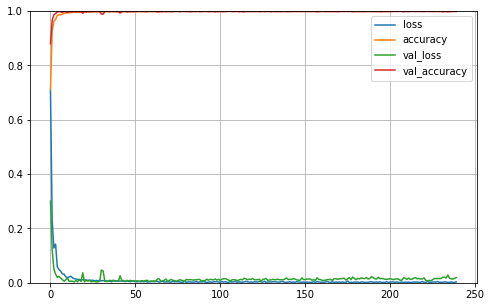

In [46]:
resultados(history2)

In [42]:
import matplotlib.pyplot as plt

def resultados(history):
    pd.DataFrame(history.history).plot(figsize = (8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.show()

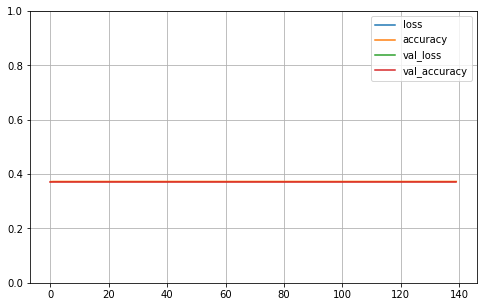

In [43]:
resultados(history)

In [ ]:
question = 'Pedro tiene 5 monedas y su abuela le da 3 más, ¿Cuántas monedas tiene en total?'

In [ ]:
question = 'Si Juan tiene 3 cajas y pierde 1, Cuantas le quedan?'

In [ ]:
question = [word for word in question.split(' ') if word not in nomb]
question = ' '.join(question)

In [ ]:
# En el conjunto de predicción nos podemos encontrar palabras que no estén
bag_q = np.zeros([1, tamanoTotal, len(palabras_unicas)+1])

In [ ]:
vocabulario['5']

In [ ]:
palabras_question = question.split(' ')

In [ ]:
len(palabras_question)

In [ ]:
tamanoTotal-len(palabras_question)

In [ ]:
for j, palabras in enumerate(palabras_question):
    print('palabra', palabras)
    print(tamanoTotal - len(palabras_question) +j)
    if palabras in vocabulario: 
        bag_q[0, tamanoTotal - len(palabras_question) + j, vocabulario[palabras]] = 1.0
    else:
        bag_q[0, tamanoTotal - len(palabras_question) + j, vocabulario['<OOP>']] = 1.0
        

In [ ]:
model2.predict(bag_q)

In [ ]:
#model.compile(loss='sparse_categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])
model.compile(loss='sparse_categorical_crossentropy',optimizer='RMSProp',metrics=['accuracy'])
#model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history = model.fit(training_X, training_y, epochs = 140, validation_data=(test_X, test_y))

In [ ]:
resultados(history)

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])

In [ ]:
history = model.fit(training_X, training_y, epochs = 140, validation_data=(test_X, test_y))

In [ ]:
resultados(history)

In [ ]:
opt = keras.optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
#opt = keras.optimizers.Adam(learning_rate = 0.0001)
model2.compile(loss='sparse_categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

In [ ]:
history2 = model2.fit(training_X, training_y, epochs = 140, batch_size= 128, validation_data=(test_X, test_y))

In [ ]:
resultados(history2)

In [ ]:
#opt = keras.optimizers.SGD(lr=0.00001, decay=1e-6, momentum=0.9, nesterov=True)
opt = keras.optimizers.Adam(learning_rate = 0.0001)
model2.compile(loss='sparse_categorical_crossentropy',optimizer=opt, metrics=['accuracy'])

In [ ]:
history2 = model2.fit(training_X, training_y, epochs = 140, batch_size= 128, validation_data=(test_X, test_y))

In [ ]:
resultados(history2)